In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
!ls /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"
###!@0 END INIT ENVIRONMENT

/content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz


In [ ]:
!rm -rf /content/data/*.csv
!mkdir /content/data
!ln -s /content/drive/MyDrive/BECommerce/olist_orders_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/olist_order_items_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/olist_products_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/olist_order_payments_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/olist_order_reviews_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/olist_customers_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/olist_geolocation_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/olist_sellers_dataset.csv /content/data/
!ln -s /content/drive/MyDrive/BECommerce/product_category_name_translation.csv /content/data/

mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

In [ ]:
from pyspark.sql.functions import col, sum, to_date, month, year, dayofmonth, dayofweek, count, avg, hour, when, datediff
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
def read_csv(path_to_file):
  return spark.read.csv(path_to_file, header=True, inferSchema=True)

orders_df = read_csv('/content/data/olist_orders_dataset.csv')
order_items_df = read_csv('/content/data/olist_order_items_dataset.csv')
products_df = read_csv('/content/data/olist_products_dataset.csv')
order_payments_df = read_csv('/content/data/olist_order_payments_dataset.csv')
order_reviews_df = read_csv('/content/data/olist_order_reviews_dataset.csv')
customers_df = read_csv('/content/data/olist_customers_dataset.csv')
geolocation_df = read_csv('/content/data/olist_geolocation_dataset.csv')
sellers_df = read_csv('/content/data/olist_sellers_dataset.csv')
product_translation_df = read_csv('/content/data/product_category_name_translation.csv')

# **Revenue Analysis**





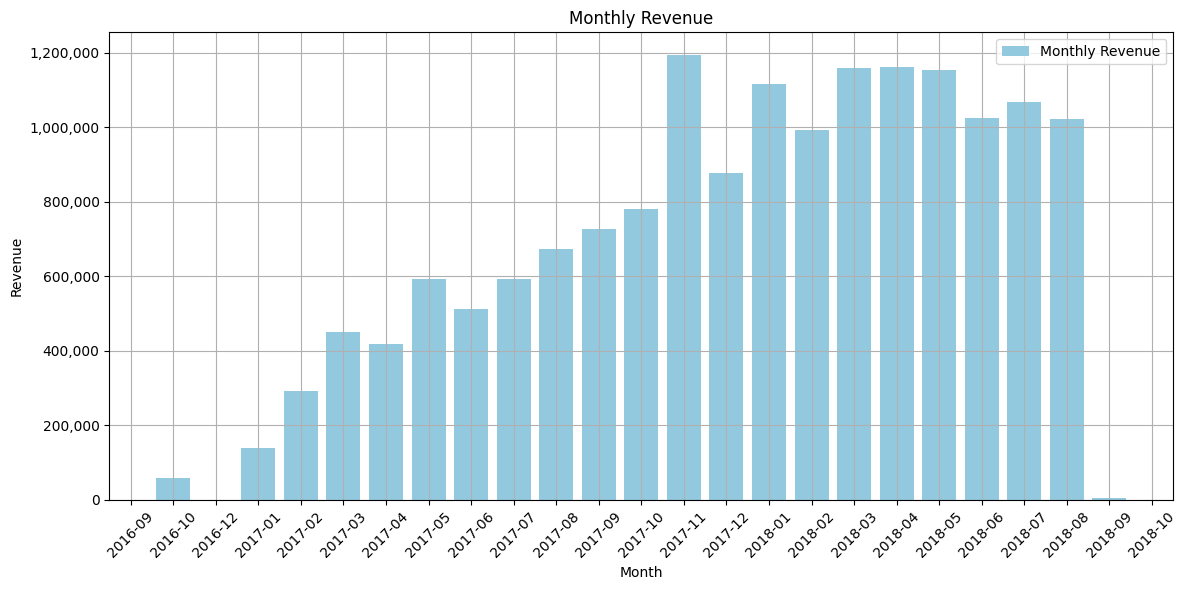

In [ ]:
revenue_df = orders_df.join(order_payments_df, "order_id")

revenue_df = revenue_df.withColumn("order_date", to_date(col("order_purchase_timestamp"))) \
    .withColumn("day_of_week", dayofweek(col("order_date"))) \
    .withColumn("month", month(col("order_date"))) \
    .withColumn("year", year(col("order_date")))

monthly_revenue_df = revenue_df.groupBy("year", "month") \
    .agg(sum("payment_value").alias("monthly_revenue")) \
    .orderBy("year", "month")

monthly_revenue = monthly_revenue_df.collect()

months = [f"{row['year']}-{row['month']:02d}" for row in monthly_revenue]
revenues = [row['monthly_revenue'] for row in monthly_revenue]

plt.figure(figsize=(12, 6))
sns.barplot(x=months, y=revenues, color='skyblue', label='Monthly Revenue')

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Monthly Revenue")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.grid(True)
plt.tight_layout()
plt.show()


From the above metrics, we can observe that revenue generally increases over time, albeit with some fluctuations. Notably, there was a sudden spike in revenue from October to November 2017, followed by a significant dip in the subsequent month. This pattern suggests a potential seasonal or promotional influence on sales during this period.

To gain deeper insights, it would be beneficial to further analyze the revenue for November 2017 on a day-by-day basis. This detailed analysis could help identify specific days or events that contributed to the spike in revenue, providing valuable information for future marketing and sales strategies.

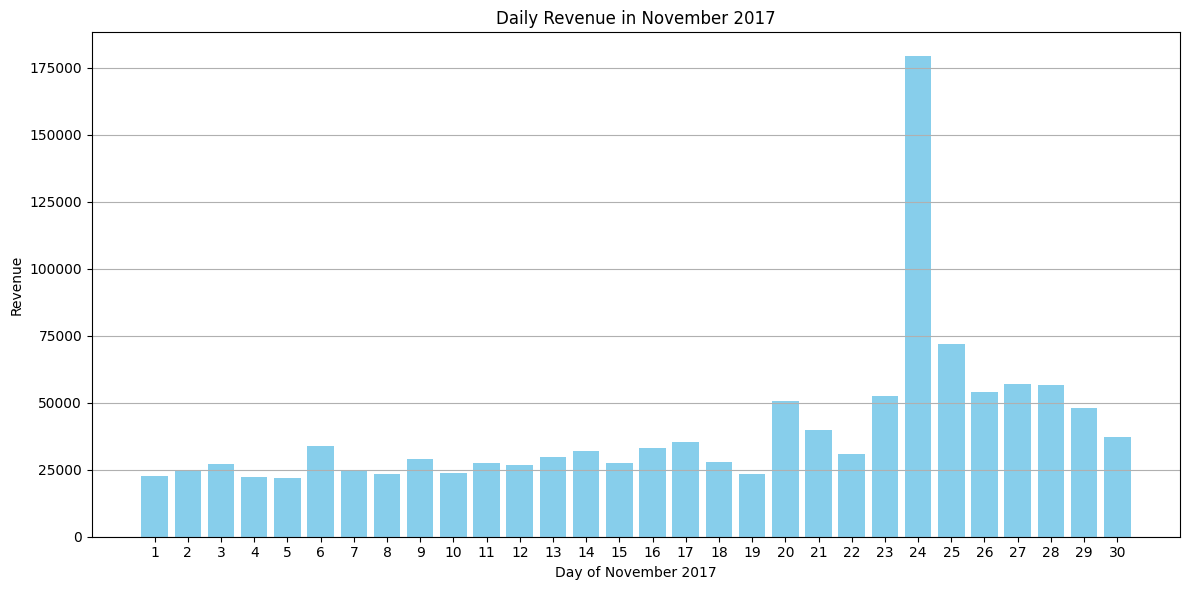

In [ ]:
revenue_2017_11_df = revenue_df.filter((col("order_date") >= "2017-11-01") & (col("order_date") <= "2017-11-30"))

daily_revenue_df = revenue_2017_11_df.groupBy(dayofmonth(col("order_date")).alias("day")) \
    .agg(sum("payment_value").alias("daily_revenue")) \
    .orderBy("day")

daily_revenue_data = daily_revenue_df.collect()

days = [row['day'] for row in daily_revenue_data]
revenues = [row['daily_revenue'] for row in daily_revenue_data]

plt.figure(figsize=(12, 6))
plt.bar(days, revenues, color='skyblue')
plt.xticks(days)
plt.xlabel("Day of November 2017")
plt.ylabel("Revenue")
plt.title("Daily Revenue in November 2017")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

"A notable spike in revenue was observed on November 24th, 2017, which aligns with Black Friday, a significant shopping event. This indicates a strong correlation between the holiday season and increased customer activity.

To optimize resource allocation for future peak seasons, a strategic approach can be implemented to dynamically scale computing resources. By scaling instances during periods of high demand, such as Black Friday, the system can handle increased traffic and prevent performance degradation. This proactive measure ensures a seamless customer experience and maximizes revenue potential."

# Order analysis

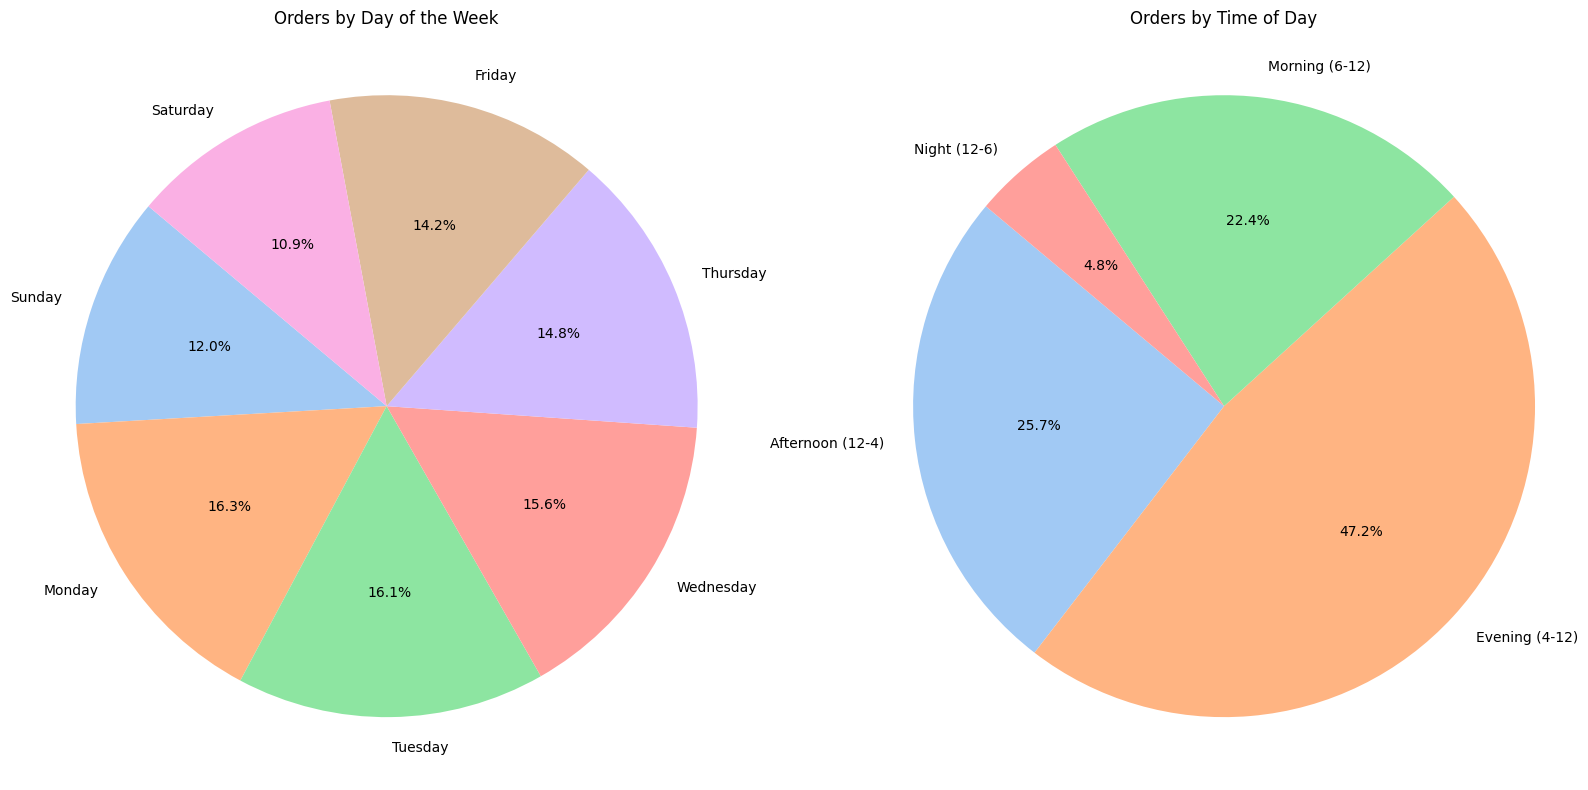

In [ ]:
# Define the time ranges for different parts of the day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning (6-12)'
    elif 12 <= hour < 16:
        return 'Afternoon (12-4)'
    elif 16 <= hour < 24:
        return 'Evening (4-12)'
    else:
        return 'Night (12-6)'

# Add a new column for the day of the week
orders_df = orders_df.withColumn("day_of_week", dayofweek(col("order_purchase_timestamp")))

# Group by day of the week and count the number of orders
day_of_week_orders_df = orders_df.groupBy("day_of_week").count().orderBy("day_of_week")

# Collect the data
day_of_week_orders = day_of_week_orders_df.collect()

# Mapping from day number to day name
day_mapping = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}

day_names = [day_mapping[row['day_of_week']] for row in day_of_week_orders]
day_of_week_order_counts = [row['count'] for row in day_of_week_orders]

# Add a new column for the time of day
orders_df = orders_df.withColumn("order_hour", hour(col("order_purchase_timestamp")))
orders_df = orders_df.withColumn("time_of_day", when((col("order_hour") >= 6) & (col("order_hour") < 12), 'Morning (6-12)')
                                             .when((col("order_hour") >= 12) & (col("order_hour") < 16), 'Afternoon (12-4)')
                                             .when((col("order_hour") >= 16) & (col("order_hour") < 24), 'Evening (4-12)')
                                             .otherwise('Night (12-6)'))

# Group by time of day and count the number of orders
time_of_day_orders_df = orders_df.groupBy("time_of_day").count().orderBy("time_of_day")

# Collect the data
time_of_day_orders = time_of_day_orders_df.collect()

# Extract the time of day labels and order counts
time_of_day_labels = [row['time_of_day'] for row in time_of_day_orders]
time_of_day_order_counts = [row['count'] for row in time_of_day_orders]

# Plot the pie charts side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for orders by day of the week
ax1.pie(day_of_week_order_counts, labels=day_names, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
ax1.set_title("Orders by Day of the Week")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Pie chart for orders by time of day
ax2.pie(time_of_day_order_counts, labels=time_of_day_labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
ax2.set_title("Orders by Time of Day")
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()


The analysis suggests that the majority of orders are placed during the evening hours (4 PM to 12 AM), indicating a preference for late-night shopping. While there is a noticeable difference in order volume between weekdays and weekends, a definitive pattern is not evident.

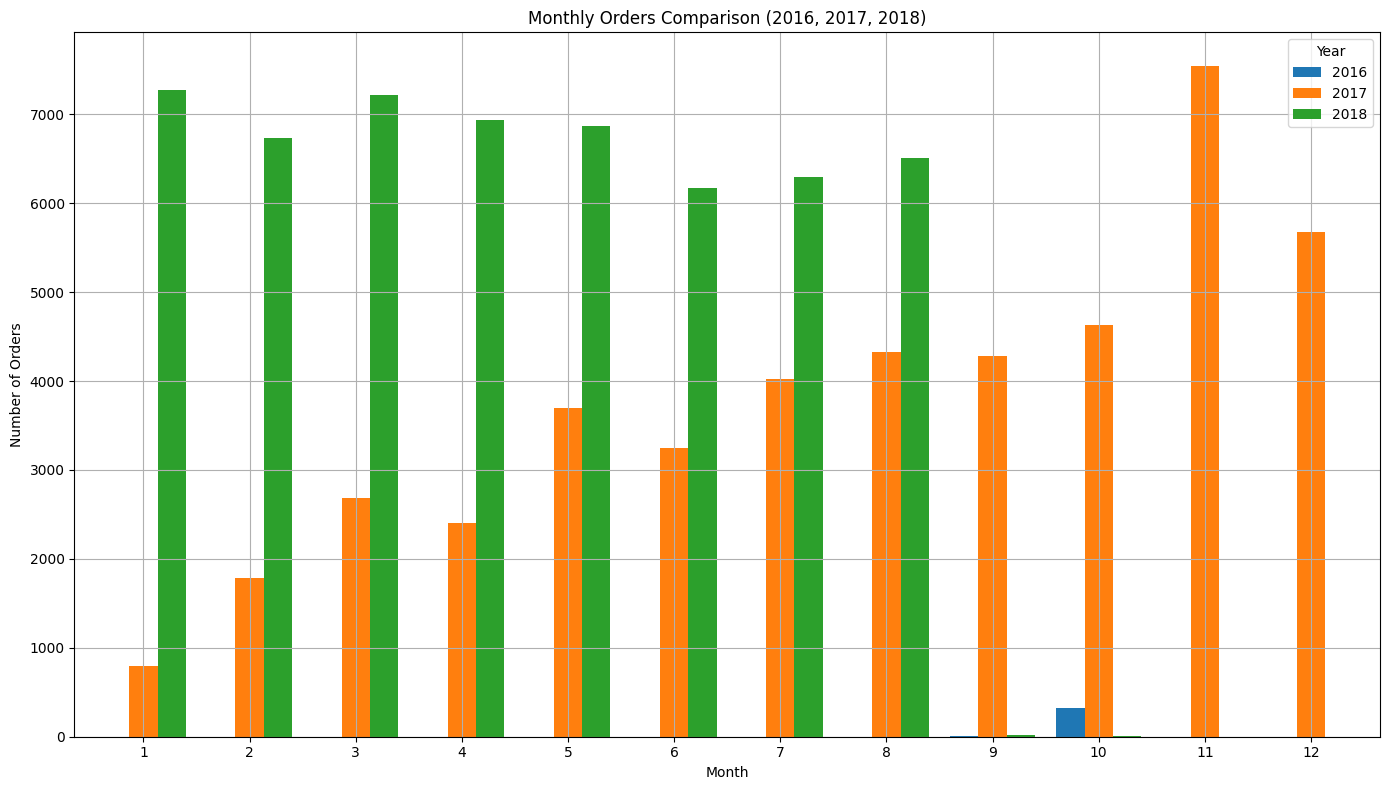

In [ ]:
# Extract year and month from the order purchase timestamp
orders_df = orders_df.withColumn("order_year", year(col("order_purchase_timestamp"))) \
                     .withColumn("order_month", month(col("order_purchase_timestamp")))

# Filter the data for the years 2016, 2017, and 2018
filtered_orders_df = orders_df.filter((col("order_year") == 2016) |
                                      (col("order_year") == 2017) |
                                      (col("order_year") == 2018))

# Group by year and month and count the number of orders
monthly_orders_df = filtered_orders_df.groupBy("order_year", "order_month").count().orderBy("order_year", "order_month")

# Convert to Pandas DataFrame for plotting
monthly_orders_pd = monthly_orders_df.toPandas()
monthly_orders_pd.columns = ['Year', 'Month', 'Order Count']

# Pivot the DataFrame to get the data in the format required for plotting
pivot_df = monthly_orders_pd.pivot(index='Month', columns='Year', values='Order Count').fillna(0)

# Plot the bar graph
pivot_df.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.title("Monthly Orders Comparison (2016, 2017, 2018)")
plt.xticks(rotation=0)
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

A comparison of 2017 and 2018 reveals a significant increase in orders, demonstrating the company's year-over-year growth.

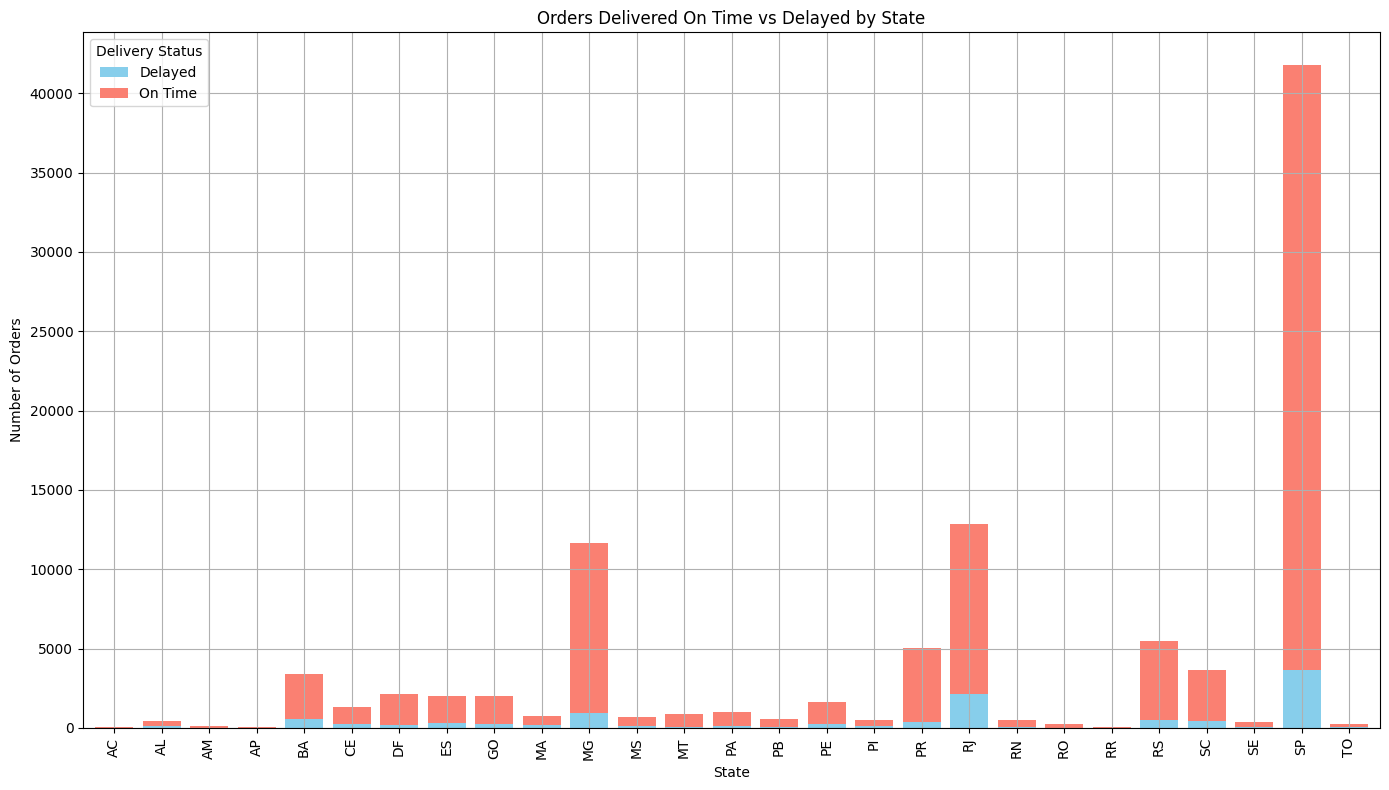

In [ ]:
# Calculate whether each order was delivered on time or delayed
orders_df = orders_df.withColumn("delivery_status", when(col("order_delivered_customer_date") <= col("order_estimated_delivery_date"), "On Time").otherwise("Delayed"))

# Join orders with customers to get state information
orders_customers_df = orders_df.join(customers_df, "customer_id")

# Group by state and delivery status and count the number of orders
state_delivery_status_df = orders_customers_df.groupBy("customer_state", "delivery_status").count().orderBy("customer_state")

# Convert to Pandas DataFrame for plotting
state_delivery_status_pd = state_delivery_status_df.toPandas()
state_delivery_status_pd.columns = ['State', 'Delivery Status', 'Order Count']

# Pivot the DataFrame to get the data in the format required for plotting
pivot_df = state_delivery_status_pd.pivot(index='State', columns='Delivery Status', values='Order Count').fillna(0)

# Plot the bar graph
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, color=['skyblue', 'salmon'])
plt.xlabel("State")
plt.ylabel("Number of Orders")
plt.title("Orders Delivered On Time vs Delayed by State")
plt.xticks(rotation=90)
plt.legend(title='Delivery Status')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis of the recent data indicates that certain states exhibit a higher percentage of delayed orders compared to others. This discrepancy necessitates a deeper investigation into the underlying causes of delays in these specific regions.

<ipython-input-75-4d9cbf0aa039>:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




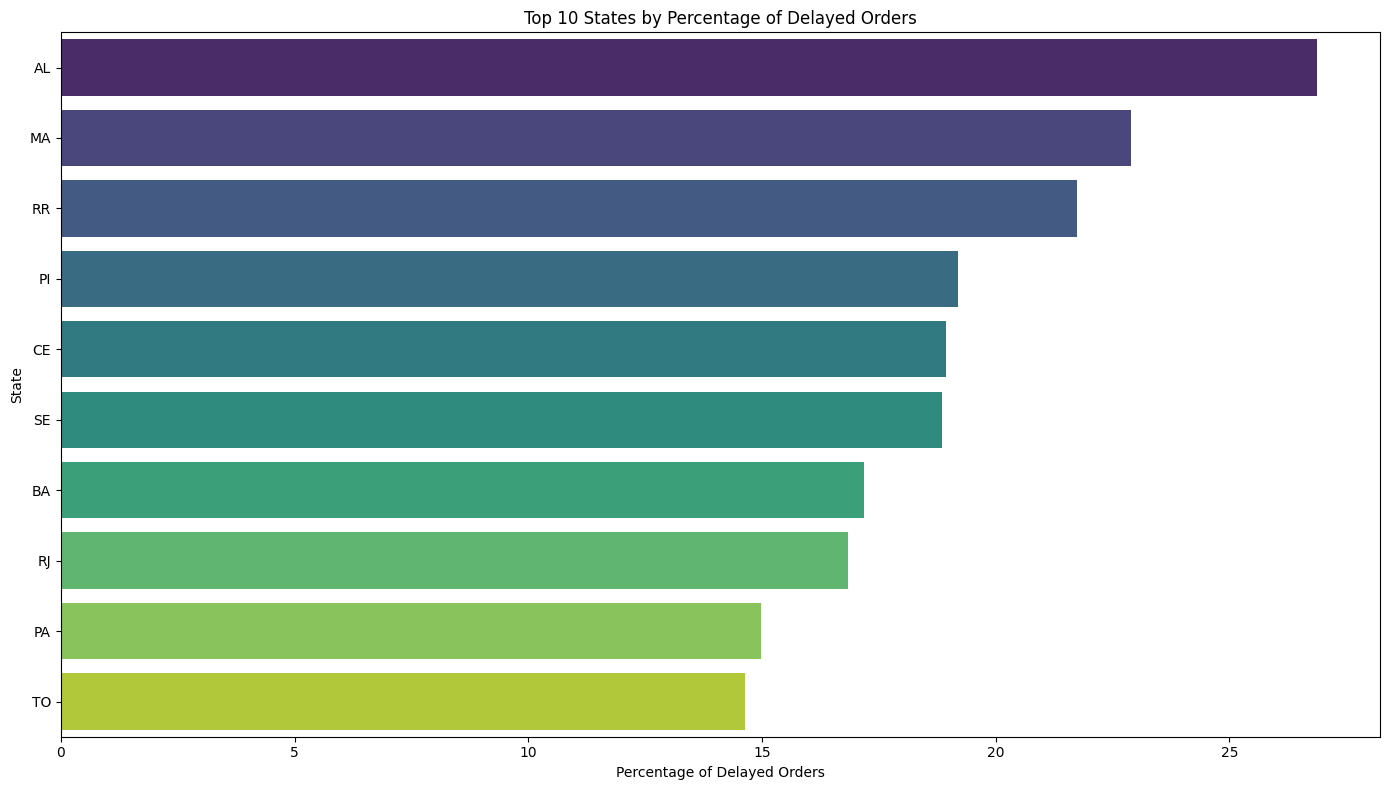

In [ ]:

# Calculate whether each order was delivered on time or delayed
orders_df = orders_df.withColumn("delivery_status", when(col("order_delivered_customer_date") <= col("order_estimated_delivery_date"), "On Time").otherwise("Delayed"))

# Join orders with customers to get state information
orders_customers_df = orders_df.join(customers_df, "customer_id")

# Filter for delayed orders
delayed_orders_df = orders_customers_df.filter(col("delivery_status") == "Delayed")

# Group by state and count the number of delayed orders
state_delayed_orders_df = delayed_orders_df.groupBy("customer_state").count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame for plotting
state_delayed_orders_pd = state_delayed_orders_df.toPandas()
state_delayed_orders_pd.columns = ['State', 'Delayed Order Count']

# Calculate the percentage of delayed orders for each state
total_orders_state_df = orders_customers_df.groupBy("customer_state").count().orderBy("customer_state")
total_orders_state_pd = total_orders_state_df.toPandas()
total_orders_state_pd.columns = ['State', 'Total Order Count']

# Merge total orders and delayed orders dataframes
merged_df = pd.merge(total_orders_state_pd, state_delayed_orders_pd, on='State', how='left').fillna(0)
merged_df['Delayed Order Percentage'] = (merged_df['Delayed Order Count'] / merged_df['Total Order Count']) * 100

# Sort the DataFrame by Delayed Order Percentage and select the top 10
top_10_df = merged_df.sort_values(by='Delayed Order Percentage', ascending=False).head(10)

# Plot the bar graph for the top 10 states by delayed order percentage
plt.figure(figsize=(14, 8))
sns.barplot(x='Delayed Order Percentage', y='State', data=top_10_df, palette="viridis")

plt.xlabel("Percentage of Delayed Orders")
plt.ylabel("State")
plt.title("Top 10 States by Percentage of Delayed Orders")
plt.tight_layout()
plt.show()


It is recommended that the company conducts a comprehensive review of its logistics and delivery operations in the states with significant delays. By identifying bottlenecks and inefficiencies, the company can optimize delivery times, ensuring timely fulfillment and enhancing operational efficiency in these regions.

In [ ]:
# Calculate whether each order was delivered on time or delayed
orders_df = orders_df.withColumn("delivery_status", when(col("order_delivered_customer_date") <= col("order_estimated_delivery_date"), "On Time").otherwise("Delayed"))

# Join orders with customers to get state information
orders_customers_df = orders_df.join(customers_df, "customer_id")

# Calculate the average review score by state
orders_customers_reviews_df = orders_customers_df.join(order_reviews_df, "order_id")
state_avg_review_score_df = orders_customers_reviews_df.groupBy("customer_state").agg(avg("review_score").alias("avg_review_score")).orderBy("customer_state")

# Calculate the percentage of delayed orders by state
total_orders_state_df = orders_customers_df.groupBy("customer_state").count().orderBy("customer_state")
delayed_orders_df = orders_customers_df.filter(col("delivery_status") == "Delayed")
state_delayed_orders_df = delayed_orders_df.groupBy("customer_state").count().orderBy("customer_state")

# Convert to Pandas DataFrames for merging and plotting
state_avg_review_score_pd = state_avg_review_score_df.toPandas()
state_avg_review_score_pd.columns = ['State', 'Average Review Score']

total_orders_state_pd = total_orders_state_df.toPandas()
total_orders_state_pd.columns = ['State', 'Total Order Count']

state_delayed_orders_pd = state_delayed_orders_df.toPandas()
state_delayed_orders_pd.columns = ['State', 'Delayed Order Count']

# Merge total orders and delayed orders dataframes
merged_df = pd.merge(total_orders_state_pd, state_delayed_orders_pd, on='State', how='left').fillna(0)
merged_df['Delayed Order Percentage'] = (merged_df['Delayed Order Count'] / merged_df['Total Order Count']) * 100

# Merge with average review score dataframe
final_df = pd.merge(merged_df, state_avg_review_score_pd, on='State')

# Plot the scatter plot using Plotly
fig = px.scatter(final_df, x='Delayed Order Percentage', y='Average Review Score', text='State',
                 title="Relationship between Delayed Orders and Average Review Score by State",
                 labels={"Delayed Order Percentage": "Percentage of Delayed Orders", "Average Review Score": "Average Review Score"},
                 hover_data={'State': True, 'Delayed Order Percentage': True, 'Average Review Score': True})

fig.update_traces(marker=dict(size=12, opacity=0.8),
                  textposition='top center')

fig.update_layout(autosize=False, width=1000, height=600,
                  margin=dict(l=40, r=40, b=40, t=40),
                  hovermode='closest')

fig.show()

The analysis has revealed a strong correlation between delayed orders and reduced customer satisfaction, as evidenced by lower satisfaction scores in customer reviews from these states. Addressing these delays is crucial to improving customer satisfaction and fostering positive customer relationships.

#***Product reviews***

<ipython-input-77-a8ca8fb05885>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




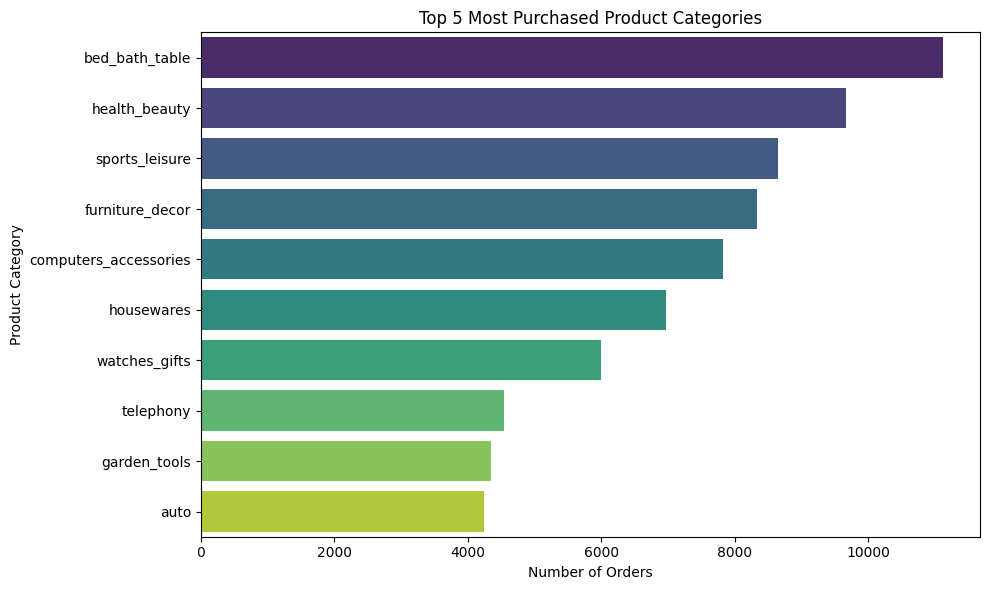

In [ ]:
order_product_df = order_items_df.join(products_df, "product_id")

# Join with translation data to get English category names
order_product_translated_df = order_product_df.join(
    product_translation_df,
    order_product_df.product_category_name == product_translation_df.product_category_name,
    "inner"
)

# Group by English category name and count the number of orders for each category
category_order_count_df = order_product_translated_df.groupBy("product_category_name_english") \
    .agg(count("order_id").alias("order_count")) \
    .orderBy(col("order_count").desc())

# Collect the top 5 categories
top_5_categories = category_order_count_df.limit(10).collect()


# Extract data for plotting
categories = [row['product_category_name_english'] for row in top_5_categories]
counts = [row['order_count'] for row in top_5_categories]

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=categories, palette="viridis")
plt.xlabel("Number of Orders")
plt.ylabel("Product Category")
plt.title("Top 5 Most Purchased Product Categories")
plt.tight_layout()
plt.show()

In [ ]:
def get_top_products_by_state(state):
    orders_with_customers_df = orders_df.join(customers_df, "customer_id")
    orders_by_state_df = orders_with_customers_df.filter(col("customer_state") == state)
    order_items_by_state_df = order_items_df.join(orders_by_state_df, "order_id")
    products_by_state_df = order_items_by_state_df.join(products_df, "product_id")
    products_translated_df = products_by_state_df.join(
        product_translation_df,
        products_by_state_df.product_category_name == product_translation_df.product_category_name,
        "inner"
    )
    top_sold_products_df = products_translated_df.groupBy("product_category_name_english") \
        .agg(count("order_id").alias("order_count")) \
        .orderBy(col("order_count").desc()) \
        .limit(5)

    reviews_with_products_df = order_reviews_df.join(order_items_df, "order_id")
    products_with_reviews_translated_df = reviews_with_products_df.join(products_df, "product_id") \
        .join(
            product_translation_df,
            products_df.product_category_name == product_translation_df.product_category_name,
            "inner"
        )

    reviewed_products_df = products_with_reviews_translated_df.groupBy("product_category_name_english") \
        .agg(avg("review_score").alias("avg_review_score"))
    top_reviewed_products_df = reviewed_products_df.orderBy(col("avg_review_score").desc()).limit(5)
    bottom_reviewed_products_df = reviewed_products_df.orderBy(col("avg_review_score").asc()).limit(5)

    print("Top 5 Sold Products in State with no of buys:", state)
    for row in top_sold_products_df.collect():
        print(f"{row['product_category_name_english']}, {row['order_count']}")

    print("\nTop 5 Reviewed Products with avg rating:")
    for row in top_reviewed_products_df.collect():
        print(f"{row['product_category_name_english']}, {row['avg_review_score']:.2f}")

    print("\nBottom 5 Reviewed Products:")
    for row in bottom_reviewed_products_df.collect():
        print(f"{row['product_category_name_english']}, {row['avg_review_score']:.2f}")

get_top_products_by_state("SP")

Top 5 Sold Products in State with no of buys: SP
bed_bath_table, 5235
health_beauty, 4204
sports_leisure, 3667
furniture_decor, 3531
housewares, 3265

Top 5 Reviewed Products with avg rating:
cds_dvds_musicals, 4.64
fashion_childrens_clothes, 4.50
books_general_interest, 4.45
costruction_tools_tools, 4.44
flowers, 4.42

Bottom 5 Reviewed Products:
security_and_services, 2.50
diapers_and_hygiene, 3.26
office_furniture, 3.49
home_comfort_2, 3.63
fashion_male_clothing, 3.64


The aforementioned method enables the derivation of valuable insights into product categories by taking the state as an input parameter. This method effectively identifies the top five best-selling products and the top five products with the highest review scores within a given region.

Based on these insights, the company can provide targeted product suggestions to customers, highlighting products that are popular in their specific region. This approach enhances customer engagement by aligning recommendations with local buying trends.

Additionally, the analysis highlights products with lower average review scores. The company can focus on these products to understand the underlying causes of dissatisfaction. By investigating and addressing these issues, the company can enhance product quality and customer satisfaction, ultimately strengthening the brand's reputation.

#**Predict customer Satisfaction**






### **1.   Data Cleaning and Preprocessing**


*   **Removed Missing Values:** Used .dropna() to remove rows with missing values in the orders_df.
*   **Removed Duplicates:** Used .dropDuplicates() on order_id in order_items_df to ensure each order ID has unique entries.
*   **Filled Missing Values:** Replaced null values in the review_comment_message column with an empty string '' using .fillna().
*   **Converted Date Columns:** Transformed order_purchase_timestamp, order_delivered_customer_date, order_delivered_carrier_date, and order_estimated_delivery_date columns to a uniform date format for consistency using to_date.
*   **Created Positive Review Indicator:** Added a column is_positive_review to identify reviews with a score of 5 and a non-empty review comment.
*   **Encoded Customer Satisfaction:** Introduced a binary target column customer_satisfaction to label scores above 4 as satisfied (1), otherwise not satisfied (0).


### **2.   Feature Engineering**


*   **Delivery Time Calculation:** Added a delivery_time column to compute the difference (in days) between order_delivered_customer_date and order_purchase_timestamp using datediff.
*   **On-Time Delivery Indicator:** Created a binary feature delivered_on_time to indicate whether the delivery occurred on or before the order_estimated_delivery_date.
*   **Shipped on Time:** Added a column shipped_on_time to check if the order_delivered_carrier_date was before or equal to the shipping_limit_date.
*   **Joined DataFrames:** Combined order_reviews_df, orders_df, order_items_df, and order_payments_df using successive .join() operations on the order_id.
*   **Dropped Rows with Missing Values:** Ensured all rows in the final dataset had complete data using .dropna().


### **3.   Feature Transformation**


*   **Excluded Target Variable:** Excluded customer_satisfaction (the target) from the feature set.
*   **Vector Assembler:** Combined the selected features into a single feature vector using VectorAssembler with inputCols as the selected features and outputCol as "features".


### **4.   Model Building and Evaluation**


*   **Random Forest Classifier:** Used a RandomForestClassifier with 100 trees (numTrees=100) to predict customer_satisfaction based on the engineered features.
*   **Train-Test Split:** Split the dataset into 80% training and 20% testing using .randomSplit().
*   **Accuracy:** Used MulticlassClassificationEvaluator with the accuracy metric to evaluate overall prediction accuracy.
*   **Precision:** Evaluated the weighted precision score across all classes.
*   **Recall:** Computed the weighted recall score, measuring the proportion of correctly identified instances of each class.
*   **F1 Score:** Calculated the F1 Score, which balances precision and recall.


In [ ]:
orders_df = orders_df.dropna()

orders_df = orders_df.withColumn('order_purchase_timestamp', to_date(col('order_purchase_timestamp'))) \
    .withColumn('order_delivered_customer_date', to_date(col('order_delivered_customer_date'))) \
    .withColumn('order_delivered_carrier_date', to_date(col('order_delivered_carrier_date'))) \
    .withColumn('order_estimated_delivery_date', to_date(col('order_estimated_delivery_date')))

orders_df = orders_df.withColumn(
    'delivered_on_time',
    when(col('order_delivered_customer_date') <= col('order_estimated_delivery_date'), 1).otherwise(0)
)

orders_df = orders_df.withColumn(
    'delivery_time',
    datediff(col('order_delivered_customer_date'), col('order_purchase_timestamp'))
)

order_items_df = order_items_df.dropDuplicates(subset=['order_id'])

order_reviews_df = order_reviews_df.fillna({'review_comment_message': ''})
order_reviews_df = order_reviews_df.withColumn(
    'is_positive_review',
    when(
        (col('review_score') == 5) & (col('review_comment_message') != ""),
        1
    ).otherwise(0)
)

order_reviews_df = order_reviews_df.withColumn(
    'customer_satisfaction',
    when(col('review_score') > 4, 1).otherwise(0))

order_payments_df = order_payments_df.dropDuplicates(subset=['order_id'])

data_df = order_reviews_df.join(orders_df, on="order_id", how="left") \
    .join(order_items_df, on="order_id", how="left") \
    .join(order_payments_df, on="order_id", how="left")

data_df = data_df.withColumn(
    'shipped_on_time',
    when(
        (col('order_delivered_carrier_date') <= col('shipping_limit_date')) &
        (col('order_delivered_carrier_date').isNotNull()),
        1
    ).otherwise(0)
)



final_data_df = data_df.select('shipped_on_time', 'delivered_on_time', 'delivery_time','payment_value', 'freight_value', 'is_positive_review', 'customer_satisfaction')
final_data_df = final_data_df.dropna()


In [ ]:
columns_to_exclude = ['customer_satisfaction']

feature_columns = [col for col in final_data_df.columns if col not in columns_to_exclude]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(final_data_df)

data = assembled_data.select("features", "customer_satisfaction")

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="customer_satisfaction", featuresCol="features", numTrees=100, seed=42)
model = rf.fit(train_data)
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="customer_satisfaction", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

precision = MulticlassClassificationEvaluator(labelCol="customer_satisfaction", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol="customer_satisfaction", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)
f1_score = MulticlassClassificationEvaluator(labelCol="customer_satisfaction", predictionCol="prediction", metricName="f1").evaluate(predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.67
Precision: 0.66
Recall: 0.67
F1 Score: 0.65


#**Customer Retention Strategy Based on Previous Analysis**


---


Based on our predictive modeling, we have identified customers who are likely to discontinue their engagement with our company. To mitigate this risk and enhance customer retention, we propose the following strategic initiatives:


1.   ***Targeted Promotions:*** Focus on providing personalized promotions to at-risk customers. By offering tailored incentives, we can improve customer loyalty and reduce churn.
2.   ***Product Recommendations:*** Utilize data analytics to identify trending products with high review scores in the customer's state or region. These products should be highlighted and recommended to customers, leveraging their proven popularity and satisfaction metrics.
3.   ***Optimized Communication:*** Based on previous analyses, the evening is the most effective time for customer engagement. Therefore, we recommend scheduling notifications and promotions through our app to reach customers during this peak period, maximizing the likelihood of interaction and purchase.
4.   ***Enhanced Delivery Strategy:*** Develop a comprehensive strategy to ensure timely delivery of products to these customers. By focusing on improving delivery times, we can significantly boost customer satisfaction, leading to increased revenue and customer retention.


Implementing these strategies will not only help retain customers but also strengthen our market position by building trust and loyalty among our customer base.

#**Scalability Considerations for Data Analytics and Modeling**

---



As our dataset spans approximately 20 months and continues to grow, it is crucial to ensure our data analytics and modeling processes remain efficient and scalable. By leveraging Apache Spark, we can maintain robust data analysis capabilities with minimal impact on processing time, even as the dataset expands over several years. Spark's distributed computing framework allows us to employ distributed modeling techniques, significantly enhancing model performance and scalability.

Furthermore, all raw data is securely stored in a data lake. This architecture is inherently scalable, accommodating increasing volumes of data seamlessly. The data lake's flexible storage capacity ensures that as our data grows, it can be efficiently managed and accessed for analytics.

Data ingestion is facilitated by Apache Kafka, a scalable messaging system designed to handle high-throughput data streams. Kafka's ability to efficiently manage large volumes of real-time data ensures that our data pipeline remains robust and responsive, supporting our analytics infrastructure.

By integrating these technologies, we ensure that our data analytics and modeling processes are well-equipped to scale alongside our expanding dataset, maintaining performance and accuracy.


